# Overview
This notebook demonstrates some of the features of the `wtphm` module, for showing how it was used in a real-world example.

# Initialisation

## Libraries

In [74]:
cd google drive/ucc/phd/code/modules/wtphm

[WinError 3] The system cannot find the path specified: 'google drive/ucc/phd/code/modules/wtphm'
C:\Users\leahy\google drive\ucc\phd\code\modules


In [75]:
import wtphm

In [76]:
cd

C:\Users\leahy


In [77]:
cd google drive/ucc/phd/code/modules

C:\Users\leahy\google drive\ucc\phd\code\modules


In [78]:
# display plots & graphs in browser:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from matplotlib.ticker import FormatStrFormatter

from sklearn.model_selection import TimeSeriesSplit, LeavePGroupsOut, \
    GroupKFold, cross_validate, GridSearchCV
from sklearn.metrics import f1_score, classification_report, \
    precision_recall_fscore_support, precision_score, recall_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, \
    SelectKBest
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

import warnings
import pickle
import imp

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.pipeline import make_pipeline as make_imbpipeline
from imblearn.under_sampling import RandomUnderSampler

from print_full import print_full

from IPython.display import display

## Importing Data

`scada` and `events` data:

In [79]:
hdf_str = 'C:\\Users\\leahy\\Google Drive\\UCC\\PhD\\Authored Papers\\'\
           'Paper 2\\pickle data\\HDF5_data.h5'

imp_path = 'C:/Users/leahy/Google Drive/UCC/PhD/Code/modules/wtphm/'\
    'examples/'

events = pd.read_csv(imp_path + 'events_data.csv',
                     parse_dates=['time_on', 'time_off'])
events.duration = pd.to_timedelta(events.duration)

scada = pd.read_hdf(hdf_str, 'scada_all_pitch').reset_index()

inv_path = 'C:\\Users\\leahy\\Google Drive\\UCC\\PhD\\Authored Papers\\' \
           'Paper 3\\investigations'

cols = [
    'turbine_num', 'time', 'kw', 'wind_speed', 'ot', 'sot',
    'dt', 'lot', 'wot', 'est', 'mt', 'rt', 'stoppage',
    'pre_stop', 'batch_id']

In [80]:
events.head()

,turbine_num,code,time_on,time_off,duration,stop_cat,description
0,20,9,2015-06-01 02:51:01,2015-06-01 02:54:13,00:03:12,ok,description anonymised
1,18,9,2015-06-01 02:51:38,2015-06-01 02:53:29,00:01:51,ok,description anonymised
2,18,84,2015-06-01 02:53:29,2015-06-01 03:00:57,00:07:28,ok,description anonymised
3,20,84,2015-06-01 02:54:13,2015-06-01 03:09:24,00:15:11,ok,description anonymised
4,18,9,2015-06-01 03:00:57,2015-06-01 03:03:46,00:02:49,ok,description anonymised


In [81]:
# codes that cause the turbine to come to a stop
stop_codes = events[events.stop_cat.isin(
    ['fault', 'maintenance', 'test', 'sensor', 'grid'])].code.unique()

# these are groups of codes, where each group represents a set of pitch-related
# events, where each memeber of the set represents the same event but along a
# different blade axis
pitch_code_groups = [[300, 301, 302], [400, 401], [501, 502, 503], [601, 602],
                     [701, 702, 703]]

In [82]:
events, stop_codes = wtphm.batch.get_grouped_event_data(
    event_data=events, code_groups=pitch_code_groups,
    fault_codes=stop_codes)

# create the batches
batches = wtphm.batch.get_batch_data(
    events, stop_codes, ok_code=207, t_sep_lim='1 hours')

A step that is currently not implemented is giving each batch a stoppage category.

Here, I've given each batch stoppage a category as per the method outlined in *Leahy, Kevin, et al. “A robust prescriptive framework and performance metric for diagnosing and predicting wind turbine faults based on SCADA and alarms data with case study.” Energies 11.7 (2018): 1738.*

In [83]:
batch_fault_cats = pd.read_csv(imp_path + 'batch_fault_cats.csv')
batch_fault_cats.fault_start_codes = batch_fault_cats.fault_start_codes.apply(
    lambda x: eval(x))
for b in batch_fault_cats.itertuples():
    batches.loc[
        batches.fault_start_codes == b.fault_start_codes, 'batch_cat'
    ] =  b.fault_cat

## Adding in Repair Category and Additional Grid categories

### Repairs

In [84]:
# add in a repair column
batches['repair'] = False
# find batches where repairs were performed
repair_batch_ids = []
for b in batches.itertuples():
    start = b.start_time
    end = (b.down_end_time + pd.Timedelta('5 minutes')).round('10T')
    batch_scada = scada[
        (scada.turbine_num == b.turbine_num) &
        (scada.time >= start) & (scada.time <= end)]
    if batch_scada.rt.sum() > 0:
        repair_batch_ids.append(b.Index)
batches.loc[repair_batch_ids, 'repair'] = True

### Grid

In [85]:
# find batches where lot counter was active:
real_grid_batch_ids = []
for b in batches.itertuples():
    start = b.start_time
    end = (b.down_end_time + pd.Timedelta('5 minutes')).round('10T')
    batch_scada = scada[
        (scada.turbine_num == b.turbine_num) & (scada.time >= start)
        & (scada.time <= end)]
    if batch_scada.lot.sum() > 0:
        real_grid_batch_ids.append(b.Index)
batches.loc[real_grid_batch_ids, 'batch_cat'] = 'grid'

## Original Scada Data

From tests, it seems the original set of scada data which wasn't edited to add calculated pitch-related features, and which doesn't break all the angles into sin and cos components, performs better than the one that does.

Here, we get the original set of scada data and also add some select features from the new set, which are the abs difference between blade angles, and the number and duration of pitch alarms in the previous 48 hours for each timestamp, as features.

The abs difference is taken from the new set of data (i.e. the one with all sin and cos components).

In [12]:
# get the original set of scada data (i.e. with degrees instead of sin and cos)
orig_scada = pd.read_hdf(hdf_str, 'scada_base_pitch')
orig_scada = orig_scada[
    (orig_scada.index.get_level_values(1) >= 'nov 2015')].reset_index()

orig_scada['blade_1_2_act_angle_diff'] = scada.loc[
    (scada.time >= 'nov 2015'), 'blade_1_2_act_angle_diff'].values

orig_scada['blade_2_3_act_angle_diff'] = scada.loc[
    (scada.time >= 'nov 2015'), 'blade_2_3_act_angle_diff'].values

orig_scada['blade_3_1_act_angle_diff'] = scada.loc[
    (scada.time >= 'nov 2015'), 'blade_3_1_act_angle_diff'].values

orig_scada['num_48h'] = scada.loc[
    (scada.time >= 'nov 2015'), 'num_48h'].values

orig_scada['dur_48h'] = scada.loc[
    (scada.time >= 'nov 2015'), 'dur_48h'].values

# Feature Engineering & Hyperparameter Search
The overall classification scheme is going to use similar features to the ones that Godwin used, as these seem to get better results than the set of features that were created previously (i.e. the ones that use the radians and sin, cos instead of straight angles, etc.).

Will be done using a test set of FULLY sampled data (i.e. the test set will not be using any balancing of classes)

This section focuses on looking at ways to preprocess the features and data, and a hyperparameter search for the random forests.

This will be done on scada data with no `min_dur`, and pre fault windows of `['48 hours', '6 hours']`.

## Data for this section

The below is the data used in the rest of this section

In [14]:
start_date = 'nov 2015'

pred_batches = batches[
    (batches.down_dur >= '0 minutes') & (batches.batch_cat == 'pitch') &
    (batches.start_time >= start_date)]

other_batches = batches[~batches.index.isin(pred_batches.index)]

rel_scada = orig_scada[(orig_scada.time >= start_date)]
# rel_scada = scada[(scada.time >= start_date)]

scada_l = wtphm.scada_labelling.label_stoppages(
        scada_data=rel_scada, fault_batches=pred_batches,
        batches_to_drop=other_batches, drop_type='stop',
        pre_stop_lims=['48 hours', '6 hours'])

scada_l = scada_l[(scada_l.ot + scada_l.sot + scada_l.wot) >= 598]

features = [
    'wind_speed', 'kw', 'wind_speed_sd', 'wind_speed_max',
    'torque_actual_value', 'blade_1_actual_angle', 'blade_2_actual_angle',
    'blade_3_actual_angle', 'blade_1_2_act_angle_diff',
    'blade_2_3_act_angle_diff', 'blade_3_1_act_angle_diff']

features_with_alarms = features + ['num_48h', 'dur_48h']

# Classification variables
X_train = scada_l.loc[scada_l.turbine_num != 2, features].values
X_test = scada_l.loc[scada_l.turbine_num == 2, features].values

y_train = scada_l.loc[scada_l.turbine_num != 2, 'pre_stop'].values
y_test = scada_l.loc[scada_l.turbine_num == 2, 'pre_stop'].values

groups = scada_l[scada_l.turbine_num != 2].turbine_num.values

## Feature Engineering & Data Exploration
Gonna check some additional features to see how they fare

Using scada data with no `min_dur`, and pre fault windows of `['48 hours', '6 hours']`

---
First, we scale the training data:

In [15]:
scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)

scaled_training_data = np.append(
    scaled_X_train, np.array([y_train]).T, axis=1)

scaled_df = pd.DataFrame(scaled_training_data, columns=features + ['pre_stop'])
pivoted_df = pd.melt(scaled_df, 'pre_stop', var_name='feature')

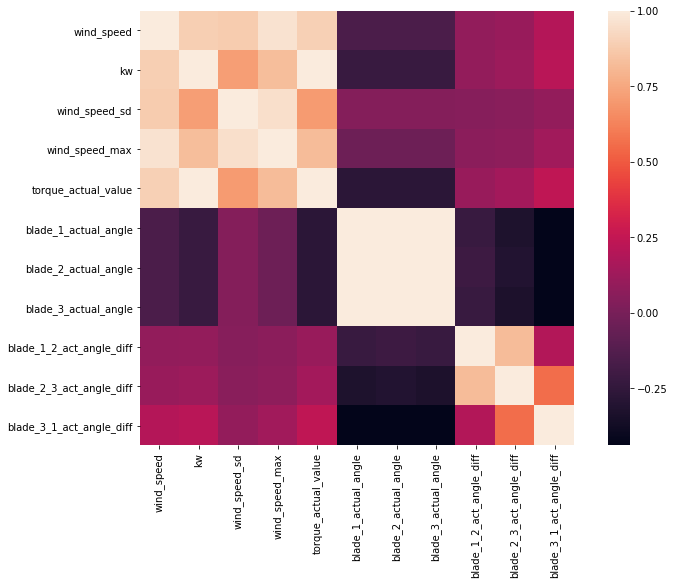

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(scaled_df[features].corr(), square=True)

C:\Users\leahy\Miniconda3\lib\site-packages\seaborn\categorical.py:647: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
C:\Users\leahy\Miniconda3\lib\site-packages\seaborn\categorical.py:895: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])
C:\Users\leahy\Miniconda3\lib\site-packages\seaborn\categorical.py:915: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


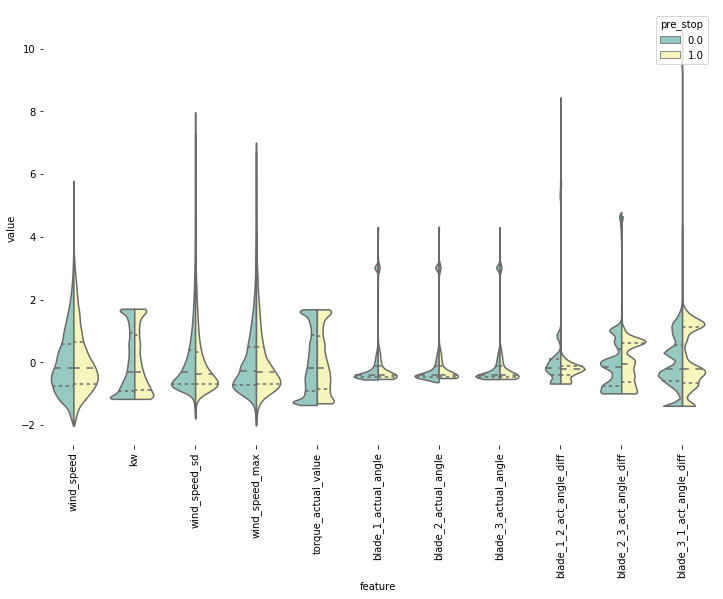

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.violinplot(
    data=pivoted_df, x='feature', y='value', split=True, hue='pre_stop',
    scale='area', palette='Set3', cut=0, lw=1, inner='quart')
sns.despine(left=True, bottom=True)

ax.set_xticklabels(features, rotation=90);

PCA without polynomial features:

In [13]:
pca = PCA(n_components=2)

X_0 = pca.fit_transform(scaled_df[scaled_df.pre_stop == 0][features].values)
X_1 = pca.fit_transform(scaled_df[scaled_df.pre_stop == 1][features].values)

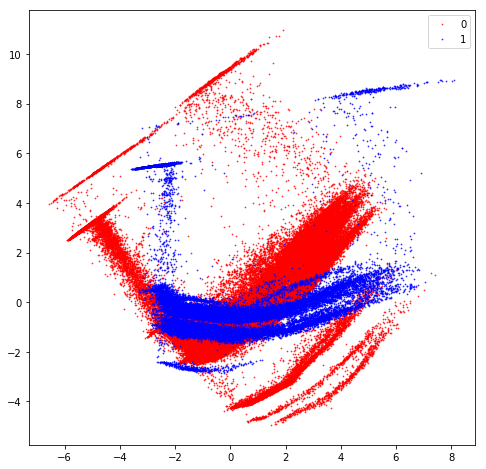

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_0[:,0], X_0[:,1], c='r', s=3,
           lw=0, alpha=0.8, marker='o', label='0')
ax.scatter(X_1[:,0], X_1[:,1], c='b', s=3,
           lw=0, alpha=0.8, marker='o', label='1')
ax.legend()

With polynomial features:

In [15]:
pipeline = make_pipeline(
    PolynomialFeatures(degree=2),
    PCA(n_components=2),
)

X_poly = pipeline.fit(scaled_df[features].values,
                      scaled_df.pre_stop.values)

X_poly0 = pipeline.transform(scaled_df[scaled_df.pre_stop == 0][features].values)
X_poly1 = pipeline.transform(scaled_df[scaled_df.pre_stop == 1][features].values)

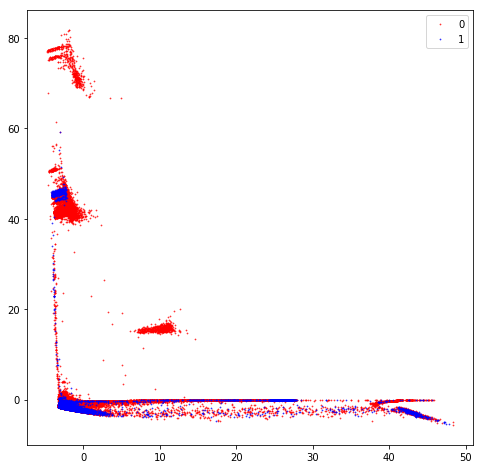

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_poly0[:,0], X_poly0[:,1], c='r', s=3,
           lw=0, alpha=0.8, marker='o', label='0')
ax.scatter(X_poly1[:,0], X_poly1[:,1], c='b', s=3,
           lw=0, alpha=0.8, marker='o', label='1')
ax.legend()

It looks like it could be worth exploring whether principal component analysis is a good idea, but it looks unlikeley that adding polynomial features will help whjen it comes to 2D PCA

## Hyperparameter Search

We're going to do a hyperparameter search for the case of [48, 6 hours] and no minimum batch duration, as intuitively this should give us a good score due to more training data being available.

This will give us a good balance of performance, as well as being able to have a minimum window in advance of predictions.

We will be performing a grid search over the following:

* Features to be inclued
    * Base features (
    `wind_speed`, `kw`, `wind_speed_sd`, `wind_speed_max`,
    `torque_actual_value`, `blade_1_actual_angle`, `blade_2_actual_angle`,
    `blade_3_actual_angle`, `blade_1_2_act_angle_diff`,
    `blade_2_3_act_angle_diff`, `blade_3_1_act_angle_diff`)
    * Base features + (`num_48h`, `dur_48h`)
* Standard Scaler
    * With Standard Scaler
    * Without
* Polynomial Features
    * 1
    * 2
    * 3
* PCA
    * no PCA
    * 2
    * 3
* RFC
    * num_estimators: [5, 10, 20]
    * max_feautures: [3, 5, 7, 11]
    
Note that turbine 2 has been randomly selected as the test set!

In [11]:
# cv scheme
lpgo = LeavePGroupsOut(n_groups=1)

# setting up the pipeline
pipe = ImbPipeline([
    ('scaler', StandardScaler()), ('rus', RandomUnderSampler(random_state=42)),
    ('plf', PolynomialFeatures()), ('pca', PCA(random_state=42)),
    ('rfc', RandomForestClassifier(n_jobs = -1, random_state=42))
])

param_grid = [{
    'scaler': [None, StandardScaler()],
    'plf': [None],
    'pca': [None],
    'rfc__n_estimators': [5, 10, 20],
    'rfc__max_features': [0.1, 0.2, 0.5, 0.7]},
    {
    'scaler': [None, StandardScaler()],
    'plf': [PolynomialFeatures(2)],
    'pca': [None],
    'rfc__n_estimators': [5, 10, 20],
    'rfc__max_features': [0.1, 0.2, 'auto']},
    {
    'scaler': [None, StandardScaler()],
    'plf': [PolynomialFeatures(3)],
    'pca': [None],
    'rfc__n_estimators': [5, 10, 20],
    'rfc__max_features': ['auto']},
    {
    'scaler': [None, StandardScaler()],
    'plf': [None, PolynomialFeatures(2), PolynomialFeatures(3)],
    'pca': [PCA(2), PCA(3)],
    'rfc__n_estimators': [5, 10, 20],
    'rfc__max_features': [0.5, 1]}]

# setting up the gridsearch
gs = GridSearchCV(pipe, param_grid=param_grid, scoring=['precision', 'recall'],
                  n_jobs=-1, cv=lpgo, refit='precision')

gs.fit(X_train, y_train, groups)

GridSearchCV(cv=LeavePGroupsOut(n_groups=1), error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rus', RandomUnderSampler(random_state=42, ratio='auto', replacement=False,
          return_indices=False)), ('plf', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('pca', PCA(copy=True, iterate...timators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'scaler': [None, StandardScaler(copy=True, with_mean=True, with_std=True)], 'plf': [None], 'pca': [None], 'rfc__n_estimators': [5, 10, 20], 'rfc__max_features': [0.1, 0.2, 0.5, 0.7]}, {'scaler': [None, StandardScaler(copy=True, with_mean=True, with_std=True)], 'plf': [PolynomialFeatures...r='auto', tol=0.0, whiten=False)], 'rfc__n_estimators': [5, 10, 20], 'rfc__max_features': [0.5, 1]}],
       pre_dispatch='2*n_jo

Next, we store the results of the above as a pickle file:

In [12]:
import pickle

with open('C:\\Users\\leahy\\Google Drive\\UCC\\PhD\\Authored Papers\\Paper 3'\
          '\\gs_results.pkl', 'wb') as file:
    pickle.dump(gs, file)

---
Next, we must find the best performing estimator from the grid search:

In [17]:
import pickle

with open('C:\\Users\\leahy\\Google Drive\\UCC\\PhD\\Authored Papers\\Paper 3'\
          '\\gs_results.pkl', 'rb') as file:
    gs = pickle.load(file)
    
gs_results = pd.DataFrame(gs.cv_results_).loc[:,[
    'mean_fit_time', 'mean_test_precision', 'mean_test_recall', 'param_pca',
    'param_plf', 'param_rfc__max_features', 'param_rfc__n_estimators',
    'param_scaler', 'params']]
print_full(gs_results.sort_values(by='mean_test_recall', ascending=False))

,mean_fit_time,mean_test_precision,mean_test_recall,param_pca,param_plf,param_rfc__max_features,param_rfc__n_estimators,param_scaler,params
60,3.431130,0.122484,0.492897,"PCA(copy=True, iterated_power='auto', n_compon...","PolynomialFeatures(degree=2, include_bias=True...",0.5,5,None,"{'pca': PCA(copy=True, iterated_power='auto', ..."
66,3.605190,0.122484,0.492897,"PCA(copy=True, iterated_power='auto', n_compon...","PolynomialFeatures(degree=2, include_bias=True...",1,5,None,"{'pca': PCA(copy=True, iterated_power='auto', ..."
54,2.289591,0.122576,0.490862,"PCA(copy=True, iterated_power='auto', n_compon...",None,1,5,None,"{'pca': PCA(copy=True, iterated_power='auto', ..."
48,2.298514,0.122576,0.490862,"PCA(copy=True, iterated_power='auto', n_compon...",None,0.5,5,None,"{'pca': PCA(copy=True, iterated_power='auto', ..."
61,3.327446,0.122550,0.489765,"PCA(copy=True, iterated_power='auto', n_compon...","PolynomialFeatures(degree=2, include_bias=True...",0.5,5,"StandardScaler(copy=True, with_mean=True, with...","{'pca': PCA(copy=True, iterated_power='auto', ..."
67,3.601382,0.122550,0.489765,"PCA(copy=True, iterated_power='auto', n_compon...","PolynomialFeatures(degree=2, include_bias=True...",1,5,"StandardScaler(copy=True, with_mean=True, with...","{'pca': PCA(copy=True, iterated_power='auto', ..."
72,7.546172,0.122767,0.489690,"PCA(copy=True, iterated_power='auto', n_compon...","PolynomialFeatures(degree=3, include_bias=True...",0.5,5,None,"{'pca': PCA(copy=True, iterated_power='auto', ..."
78,8.275514,0.122767,0.489690,"PCA(copy=True, iterated_power='auto', n_compon...","PolynomialFeatures(degree=3, include_bias=True...",1,5,None,"{'pca': PCA(copy=True, iterated_power='auto', ..."
102,3.917122,0.122739,0.489037,"PCA(copy=True, iterated_power='auto', n_compon...","PolynomialFeatures(degree=2, include_bias=True...",1,5,None,"{'pca': PCA(copy=True, iterated_power='auto', ..."
96,3.331763,0.122759,0.489037,"PCA(copy=True, iterated_power='auto', n_compon...","PolynomialFeatures(degree=2, include_bias=True...",0.5,5,None,"{'pca': PCA(copy=True, iterated_power='auto', ..."


We're going to use the hyperparameters at grid search position 54, as this gives us a good balance of precision and recall, while also being quick to train.

The precision was in the region of roughly .12 - .13, whereas recall was in the region of .2 - .49, so we'll use the one with the best recall.

---

The following are the order of the steps:

In [18]:
gs.estimator.steps

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('rus', RandomUnderSampler(random_state=42, ratio='auto', replacement=False,
            return_indices=False)),
 ('plf',
  PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)),
 ('pca',
  PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)),
 ('rfc',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
              oob_score=False, random_state=42, verbose=0, warm_start=False))]

So, we construct a new pipeline in that order with the following params:

In [19]:
gs_results.loc[54, 'params']

{'pca': PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 'plf': None,
 'rfc__max_features': 1,
 'rfc__n_estimators': 5,
 'scaler': None}

The best pipeline, to be used in the rest of this study, is then:

In [59]:
best_pipe = ImbPipeline([
    ('rus', RandomUnderSampler(ratio='majority', random_state=42)),
    ('pca', PCA(2, random_state=42)),
    ('rfc', RandomForestClassifier(
        n_jobs=-1, random_state=42, max_features=1, n_estimators=5))])

# Exploring CV scores for different `min_dur` and repair batches and prefault windows

Next, we use the hyperparameters found above to get validation scores for each of the cases of minimum batch duration/repairs and pre-fault windows.

Note that **turbine 2** is not included in this, as this is selected as the test set (for section 4: evaluation).

## Batches where repairs were carried out

This is trying to predict the performance when repairs were carried out.

batches that are not relevant are dropped from the data

---
Format the data:

In [21]:
start_date = 'nov 2015'

pred_batches = batches[
    (batches.repair == True) & (batches.batch_cat == 'pitch') &
    (batches.start_time >= start_date)]

other_batches = batches[~batches.index.isin(pred_batches.index)]

rel_scada = orig_scada[orig_scada.time >= start_date]

pre_stop_durs = [
    ['2 hours', '0 hours'], ['4 hours', '0 hours'], ['8 hours', '0 hours'],
    ['24 hours', '0 hours'], ['24 hours', '6 hours'], ['48 hours', '6 hours']]

repair_scores = {}

for dur in pre_stop_durs:

    scada_l = wtphm.event_prediction.label_stoppages(
        scada_data=rel_scada, fault_batches=pred_batches,
        batches_to_drop=other_batches, drop_type='stop',
        pre_stop_lims=dur)
    
#     scada_l = scada_l[(scada_l.ot + scada_l.sot + scada_l.wot) >= 598]
    
    scada_l = scada_l[((scada_l.ot + scada_l.sot + scada_l.wot) >= 598) &
                      (scada_l.turbine_num != 2)]

    X = scada_l[features].values

    y = scada_l['pre_stop'].values

    groups = scada_l.turbine_num.values

#     pipe = ImbPipeline([
#         ('rus', RandomUnderSampler(ratio='majority')),
#         ('rfc', RandomForestClassifier(n_jobs=-1, random_state=42))])
#     #     ('scaler', StandardScaler()),
#     #     ('svm', SVC(C=1))])
    pipe = best_pipe
    
    pipe_dum = ImbPipeline([('rus', RandomUnderSampler(ratio='majority')),
                            ('dum', DummyClassifier(random_state=42))])

    lpgo = LeavePGroupsOut(n_groups=1)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        dur_scores = cross_validate(
            pipe, X, y, groups, ['precision', 'recall'], lpgo)
        dum_scores = cross_validate(
            pipe_dum, X, y, groups, ['precision', 'recall'], lpgo)

    dur_scores = pd.DataFrame(dur_scores)
    dum_scores = pd.DataFrame(dum_scores)
    
    print(dur)
    print('scores:')
    print(dur_scores[['test_precision', 'test_recall']].mean())
    print('dummy scores:')
    print(dum_scores[['test_precision', 'test_recall']].mean())
    print()

    repair_scores[', '.join(dur)] = dur_scores

['2 hours', '0 hours']
scores:
test_precision    0.000183
test_recall       0.120833
dtype: float64
dummy scores:
test_precision    0.000280
test_recall       0.229167
dtype: float64

['4 hours', '0 hours']
scores:
test_precision    0.000535
test_recall       0.177083
dtype: float64
dummy scores:
test_precision    0.000567
test_recall       0.241667
dtype: float64

['8 hours', '0 hours']
scores:
test_precision    0.001113
test_recall       0.184375
dtype: float64
dummy scores:
test_precision    0.001100
test_recall       0.228869
dtype: float64

['24 hours', '0 hours']
scores:
test_precision    0.003658
test_recall       0.211322
dtype: float64
dummy scores:
test_precision    0.003736
test_recall       0.252920
dtype: float64

['24 hours', '6 hours']
scores:
test_precision    0.002775
test_recall       0.214568
dtype: float64
dummy scores:
test_precision    0.002933
test_recall       0.262565
dtype: float64

['48 hours', '6 hours']
scores:
test_precision    0.006166
test_recall       0

Overall, quite poor!

As will be seen, the best performance is still seen on data with a small `min_dur` and large pre fault window

## Different `min_dur`s

In [22]:
min_bat_durs = ['0 hours', '0.5 hours', '1 hour', '2 hours', '6 hours', '12 hours', 
                '24 hours']

scores_dict = {}

for min_bat_dur in min_bat_durs:
    pred_batches = batches[
        (batches.down_dur >= min_bat_dur) & (batches.batch_cat == 'pitch') &
        (batches.start_time >= start_date)]

    other_batches = batches[~batches.index.isin(pred_batches.index)]
    
    scores_dict[min_bat_dur] = {}
    for pre_stop_dur in pre_stop_durs:
        scada_l = wtphm.event_prediction.label_stoppages(
            scada_data=rel_scada, fault_batches=pred_batches,
            batches_to_drop=other_batches, drop_type='stop',
            pre_stop_lims=pre_stop_dur)

#         scada_l = scada_l[(scada_l.ot + scada_l.sot + scada_l.wot) >= 598]

        scada_l[((scada_l.ot + scada_l.sot + scada_l.wot) >= 598) &
                      (scada_l.turbine_num != 2)]

        X = scada_l[[
            'wind_speed', 'kw', 'wind_speed_sd', 'wind_speed_max', 'torque_actual_value',
            'blade_1_actual_angle', 'blade_2_actual_angle', 'blade_3_actual_angle',
            'blade_1_2_act_angle_diff', 'blade_2_3_act_angle_diff',
            'blade_3_1_act_angle_diff']].values

        y = scada_l['pre_stop'].values

        groups = scada_l.turbine_num.values

#         pipe = ImbPipeline([
#             ('rus', RandomUnderSampler(ratio='majority')),
#             ('rfc', RandomForestClassifier(n_jobs=-1, random_state=42))])
        pipe = best_pipe

        pipe_dum = ImbPipeline([('rus', RandomUnderSampler(ratio='majority')),
                                ('dum', DummyClassifier(random_state=42))])

        lpgo = LeavePGroupsOut(n_groups=1)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cur_scores = cross_validate(
                pipe, X, y, groups, ['precision', 'recall'], lpgo)
            dum_scores = cross_validate(
                pipe_dum, X, y, groups, ['precision', 'recall'], lpgo)

        cur_scores = pd.DataFrame(cur_scores)
        dum_scores = pd.DataFrame(dum_scores)

        print('scores for batch duration', min_bat_dur, 'and pre_stop',
              pre_stop_dur)
        print(cur_scores[['test_precision', 'test_recall']].mean())
        print('dummy scores:')
        print(dum_scores[['test_precision', 'test_recall']].mean())
        print()

        scores_dict[min_bat_dur][', '.join(pre_stop_dur)] = cur_scores

scores for batch duration 0 hours and pre_stop ['2 hours', '0 hours']
test_precision    0.014069
test_recall       0.515325
dtype: float64
dummy scores:
test_precision    0.009779
test_recall       0.504814
dtype: float64

scores for batch duration 0 hours and pre_stop ['4 hours', '0 hours']
test_precision    0.024163
test_recall       0.503777
dtype: float64
dummy scores:
test_precision    0.019159
test_recall       0.494545
dtype: float64

scores for batch duration 0 hours and pre_stop ['8 hours', '0 hours']
test_precision    0.040590
test_recall       0.495196
dtype: float64
dummy scores:
test_precision    0.036486
test_recall       0.483687
dtype: float64

scores for batch duration 0 hours and pre_stop ['24 hours', '0 hours']
test_precision    0.100745
test_recall       0.500283
dtype: float64
dummy scores:
test_precision    0.097987
test_recall       0.493239
dtype: float64

scores for batch duration 0 hours and pre_stop ['24 hours', '6 hours']
test_precision    0.076698
test_reca

## Results

**Note:** The `repair_scores2.pkl` and `scores_dict2.pkl` files are the results of the above experiment with optimal hyperparameters and pre-processing, and not including turbine 2 (as this is the test set). The others, i.e. `scores_dict.pkl` and `repair_scores.pkl` are from what was done previously, with a fairly basic pipeline and including turbine 2 as well.

In [23]:
with open('C:\\Users\\leahy\\Google Drive\\UCC\\PhD\\Authored Papers\\Paper 3'\
          '\\repair_scores2.pkl', 'wb') as file:
    pickle.dump(repair_scores, file)
    
with open('C:\\Users\\leahy\\Google Drive\\UCC\\PhD\\Authored Papers\\Paper 3'\
          '\\scores_dict2.pkl', 'wb') as file:
    pickle.dump(scores_dict, file)

In [38]:
with open('C:\\Users\\leahy\\Google Drive\\UCC\\PhD\\Authored Papers\\Paper 3'\
          '\\repair_scores2.pkl', 'rb') as file:
    repair_scores = pickle.load(file)
    
with open('C:\\Users\\leahy\\Google Drive\\UCC\\PhD\\Authored Papers\\Paper 3'\
          '\\scores_dict2.pkl', 'rb') as file:
    all_scores = pickle.load(file)
    
all_scores['repair'] = repair_scores

df_columns = ['fit_time', 'score_time', 'test_precision', 'test_recall',
              'train_precision', 'train_recall', 'min_dur', 'interval']

scores_df = pd.DataFrame(columns=df_columns)

for min_dur, min_dur_scores in all_scores.items():
    for k, v in min_dur_scores.items():
        cur_score = v
        cur_score['min_dur'] = min_dur
        cur_score['interval'] = k
        scores_df = scores_df.append(cur_score)

Below is just for saving the scores df rather than having to always run the above code!

In [ ]:
data_store = pd.HDFStore(
    'C:\\Users\\leahy\\Google Drive\\UCC\\PhD\\Authored Papers\\Paper 3'\
    '\\scores_data.hd5')
data_store['journal_cv_scores'] = scores_df

In [ ]:
data_store = pd.HDFStore(
    'C:\\Users\\leahy\\Google Drive\\UCC\\PhD\\Authored Papers\\Paper 3'\
    '\\scores_data.hd5')
scores_df = data_store['journal_cv_scores']

score_cols = ['test_precision', 'test_recall']
scores_df_melt = scores_df.melt(
    id_vars=scores_df.columns.drop(score_cols), value_vars=score_cols,
    value_name='score', var_name='score_type')

C:\Users\leahy\Miniconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


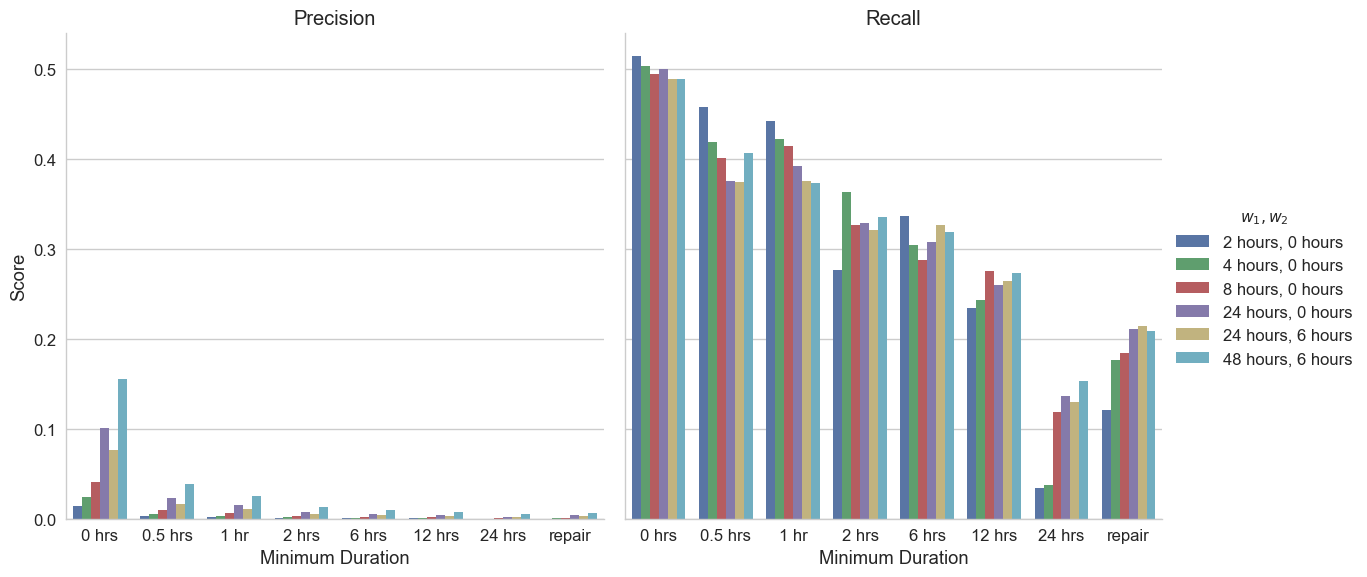

In [40]:
sns.set(font_scale=1.2)
sns.set_style('whitegrid')

# mpl.rcParams['mathtext.fontset'] = 'stix'
# mpl.rcParams['mathtext.fontsize'] = 10
# mpl.rcParams['text.usetex'] = True

g = sns.factorplot(
    x='min_dur', y="score", hue="interval",
    data=scores_df_melt, kind="bar", col='score_type',
    errwidth=1, capsize=0.05, size=6, ci=None)

titles = ['Precision', 'Recall']
y_labels = ['Score','']
x_ticks = ['0 hrs', '0.5 hrs', '1 hr', '2 hrs', '6 hrs', '12 hrs', '24 hrs',
           'repair']

g._legend.set_title('$w_1, w_2$')

for ax, title, y_label in zip(g.axes.flat, titles, y_labels):
    ax.set_title(title)
    ax.set_xlabel('Minimum Duration')
    ax.set_ylabel(y_label)
    ax.set_xticklabels(x_ticks)#, rotation=30)

# Final Classification on Test Set & Alarms Evaluation

This method has a moving window going through the data.

It activates when the number of times the alarm is triggered in that window is above a certain threshold.

The `test_scada` data consists of the test scada data, with irrelevant columns (i.e. the features) dropped, and the predicted label appended.

In [68]:
def classify_and_evaluate(
        pred_batches, start_date, pre_stop_lims, rel_scada, test_turbine,
        features, pipe, w, b):
    '''This function runs the final classifier on the data and performs the
    real world evaluation on turbine 2 (since this had the best classification
    score)'''
    other_batches = batches[~batches.index.isin(pred_batches.index)]

    scada_l = wtphm.event_prediction.label_stoppages(
            scada_data=rel_scada, fault_batches=pred_batches,
            batches_to_drop=other_batches, drop_type='stop',
            pre_stop_lims=pre_stop_lims)

    scada_l = scada_l[(scada_l.ot + scada_l.sot + scada_l.wot) >= 598]

#     pipe = make_imbpipeline(
#         StandardScaler(),
#         RandomUnderSampler(random_state=42),
#         PolynomialFeatures(degree=1),
#         PCA(n_components=2, random_state=42),
#         RandomForestClassifier(n_jobs=-1, random_state=42))

    train = scada_l[scada_l.turbine_num != test_turbine]
    test = scada_l[scada_l.turbine_num == test_turbine]
    
    X_train = scada_l.loc[scada_l.turbine_num != test_turbine, features].values
    X_test = scada_l.loc[scada_l.turbine_num == test_turbine, features].values

    y_train = scada_l.loc[scada_l.turbine_num != test_turbine, 'pre_stop'].values
    y_test = scada_l.loc[scada_l.turbine_num == test_turbine, 'pre_stop'].values

#     X_train = train[features].values
#     y_train = train['pre_stop'].values

#     X_test = test[features]
#     y_test = test['pre_stop'].values

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    
    print('\npre stop lims: {}'.format(pre_stop_lims))
    print('\nwindow length: {}\nthreshold limit: {:.2f}'.format(w, b))

    print('precision: {:.2%}\nrecall: {:.2%}'.format(prec, rec))
    
    # get the portion of scada data that was in the test set   
    test_scada = scada_l.loc[scada_l.turbine_num == test_turbine,
                             ['time', 'turbine_num', 'wind_speed', 'kw',
                              'stoppage', 'batch_id', 'pre_stop']]
    test_scada.loc[:, 'label'] = y_pred

    # we drop the bit of data with batch 804 in it, as this batch occurred less
    # than 48h into the data, so a full pre_stop window isn't available
    test_scada = test_scada[test_scada.batch_id != 804]

    # sum of positive labels in each window
    window_sums = test_scada.label.rolling(w).sum()

    # indices of alarms in scada data (where number of positive labels exceeds
    # threshold in each window)
    alarms = test_scada[window_sums >= b]

    # these are the actual ids of the batches that were caught
    caught_batch_ids = alarms[alarms.batch_id != -1].batch_id.unique()

    # find the time that each batch was caught, to get an idea of how much notice
    # was given
    caught_batch_info = pd.DataFrame(columns=['caught_time', 'batch_time',
                                              'notice'])
    for b_id in caught_batch_ids:
        caught_time = alarms[alarms.batch_id == b_id].time.min()
        batch_time = batches.loc[b_id, 'start_time']
        notice = batch_time - caught_time
        caught_batch_info.loc[b_id] = [caught_time, batch_time, notice]

    # the following gets all the stats for the batches and false alarms:
    num_batches = len(test_scada.batch_id.unique())
    
    print('\nminimum notice:', caught_batch_info.notice.min())
    print('maximum notice:', caught_batch_info.notice.max())
    print('average notice:', caught_batch_info.notice.mean())
    
    print('number of batches in test set: {}'.format(num_batches))
    print('\n% of caught batches: {:.2%}'.format(
        len(caught_batch_ids) / num_batches))
    print('number of caught batches: {}'.format(len(caught_batch_ids)))
    print('number of true alarms: {}'.format(
        len(alarms[alarms.batch_id != -1])))

    # total number of fault-free samples
    num_fault_free = len(test_scada[test_scada.batch_id == -1])

    # number of times it was falsely triggered:
    num_false_alarms = len(alarms[alarms.batch_id == -1])

    print('\n% of time the alarm was active when there was no fault: {:.2%}'\
          .format(num_false_alarms / num_fault_free))
    print(
        'total time alarm was active when there was no fault: {} hours'\
        .format((num_false_alarms * 10)/60))
    print('total number of false alarmds: {}'.format(num_false_alarms))
    print('caught batches: {}'.format(caught_batch_ids))

In [60]:
# note the following is just for testing!! - scores in the rest of the
# study for 48, 6 hours and no min_dur should be the following!!

start_date = 'nov 2015'

pred_batches = batches[
    (batches.down_dur >= '0 minutes') & (batches.batch_cat == 'pitch') &
    (batches.start_time >= start_date)]

other_batches = batches[~batches.index.isin(pred_batches.index)]

rel_scada = orig_scada[(orig_scada.time >= start_date)]
# rel_scada = scada[(scada.time >= start_date)]

scada_l = wtphm.event_prediction.label_stoppages(
        scada_data=rel_scada, fault_batches=pred_batches,
        batches_to_drop=other_batches, drop_type='stop',
        pre_stop_lims=['48 hours', '6 hours'])

scada_l = scada_l[(scada_l.ot + scada_l.sot + scada_l.wot) >= 598]

X_train = scada_l.loc[scada_l.turbine_num != 2, features].values
X_test = scada_l.loc[scada_l.turbine_num == 2, features].values

y_train = scada_l.loc[scada_l.turbine_num != 2, 'pre_stop'].values
y_test = scada_l.loc[scada_l.turbine_num == 2, 'pre_stop'].values

pipe = best_pipe
best_pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)

print('recall: {:.2f}\nprecision: {:.2f}'.format(rec, prec))

recall: 0.51
precision: 0.46


---
And, the evaluation:

In [83]:
start_date = 'nov 2015'

pred_batches = batches[
    (batches.down_dur >= '60 minutes') & (batches.batch_cat == 'pitch') &
    (batches.start_time >= start_date)]

rel_scada = orig_scada[(orig_scada.time >= start_date)]

pre_stop_lims = ['48 hours', '6 hours']

# all_pitch_features = np.loadtxt(
#     inv_path + '//features//all_pitch_features.csv', dtype='object')

features = [
    'wind_speed', 'kw', 'wind_speed_sd', 'wind_speed_max',
    'torque_actual_value', 'blade_1_actual_angle', 'blade_2_actual_angle',
    'blade_3_actual_angle', 'blade_1_2_act_angle_diff',
    'blade_2_3_act_angle_diff', 'blade_3_1_act_angle_diff']

w = 12
b = 12

pipe = best_pipe

classify_and_evaluate(
    pred_batches, start_date, pre_stop_lims, rel_scada, 2, features, pipe,
    w, b)


pre stop lims: ['48 hours', '6 hours']

window length: 12
threshold limit: 12.00
precision: 5.93%
recall: 47.49%

minimum notice: nan
maximum notice: nan
average notice: nan
number of batches in test set: 7

% of caught batches: 0.00%
number of caught batches: 0
number of true alarms: 0

% of time the alarm was active when there was no fault: 0.05%
total time alarm was active when there was no fault: 1.8333333333333333 hours
total number of false alarmds: 11
caught batches: []


In [77]:
batches.loc[[824, 846, 866, 881, 894]].down_dur.sum()

Timedelta('0 days 12:44:12')

batches[(batches.repair == True) & (batches.batch_cat == 'pitch')]

Same as above, but for batches that lasted 30 minutes or more with w=12 and b =12:

In [34]:
pred_batches = batches[
    (batches.down_dur >= '30 minutes') & (batches.batch_cat == 'pitch') &
    (batches.start_time >= start_date)]

rel_scada = orig_scada[(orig_scada.time >= start_date)]

pre_stop_lims = ['48 hours', '6 hours']

all_pitch_features = np.loadtxt(
    inv_path + '//features//all_pitch_features.csv', dtype='object')

features = [
    'wind_speed', 'kw', 'wind_speed_sd', 'wind_speed_max',
    'torque_actual_value', 'blade_1_actual_angle', 'blade_2_actual_angle',
    'blade_3_actual_angle', 'blade_1_2_act_angle_diff',
    'blade_2_3_act_angle_diff', 'blade_3_1_act_angle_diff']

w = 144
b = .66 * 144

classify_and_evaluate(
        pred_batches, start_date, pre_stop_lims, rel_scada, 2, features, w, b)


pre stop lims: ['48 hours', '6 hours']

window length: 144
threshold limit: 95.04
precision: 12.13%
recall: 52.99%

minimum notice: 1 days 03:12:03
maximum notice: 1 days 23:52:10
average notice: 1 days 19:31:58.600000
number of batches in test set: 13

% of caught batches: 38.46%
number of caught batches: 5
number of true alarms: 753

% of time the alarm was active when there was no fault: 20.43%
total time alarm was active when there was no fault: 709.8333333333334 hours
total number of false alarmds: 4259


Same as above, but with b set to 10:

In [104]:
pred_batches = batches[
    (batches.down_dur >= '30 minutes') & (batches.batch_cat == 'pitch') &
    (batches.start_time >= start_date)]

rel_scada = orig_scada[(orig_scada.time >= start_date)]

pre_stop_lims = ['48 hours', '6 hours']

all_pitch_features = np.loadtxt(
    inv_path + '//features//all_pitch_features.csv', dtype='object')

features = [
    'wind_speed', 'kw', 'wind_speed_sd', 'wind_speed_max',
    'torque_actual_value', 'blade_1_actual_angle', 'blade_2_actual_angle',
    'blade_3_actual_angle', 'blade_1_2_act_angle_diff',
    'blade_2_3_act_angle_diff', 'blade_3_1_act_angle_diff']

w = 12
b = 10

classify_and_evaluate(
        pred_batches, start_date, pre_stop_lims, rel_scada, 2, features, w, b)


pre stop lims: ['48 hours', '6 hours']

window length: 12
threshold limit: 10.00
precision: 12.13%
recall: 52.99%

minimum notice: 1 days 04:33:43
maximum notice: 1 days 23:52:10
average notice: 1 days 17:34:56.800000
number of batches in test set: 13

% of caught batches: 76.92%
number of caught batches: 10
number of true alarms: 648

% of time the alarm was active when there was no fault: 16.18%
total time alarm was active when there was no fault: 562.1666666666666 hours
total number of false alarmds: 3373


Same as the two above, but with min dur set to 60 minutes

In [105]:
pred_batches = batches[
    (batches.down_dur >= '60 minutes') & (batches.batch_cat == 'pitch') &
    (batches.start_time >= start_date)]

rel_scada = orig_scada[(orig_scada.time >= start_date)]

pre_stop_lims = ['48 hours', '6 hours']

all_pitch_features = np.loadtxt(
    inv_path + '//features//all_pitch_features.csv', dtype='object')

features = [
    'wind_speed', 'kw', 'wind_speed_sd', 'wind_speed_max',
    'torque_actual_value', 'blade_1_actual_angle', 'blade_2_actual_angle',
    'blade_3_actual_angle', 'blade_1_2_act_angle_diff',
    'blade_2_3_act_angle_diff', 'blade_3_1_act_angle_diff']

w = 12
b = 12

classify_and_evaluate(
        pred_batches, start_date, pre_stop_lims, rel_scada, 2, features, w, b)


pre stop lims: ['48 hours', '6 hours']

window length: 12
threshold limit: 12.00
precision: 6.01%
recall: 46.78%

minimum notice: 0 days 23:53:43
maximum notice: 1 days 23:51:01
average notice: 1 days 11:52:22
number of batches in test set: 7

% of caught batches: 28.57%
number of caught batches: 2
number of true alarms: 10

% of time the alarm was active when there was no fault: 0.58%
total time alarm was active when there was no fault: 21.666666666666668 hours
total number of false alarmds: 130


Same as above, but with b set to 10:

In [106]:
pred_batches = batches[
    (batches.down_dur >= '60 minutes') & (batches.batch_cat == 'pitch') &
    (batches.start_time >= start_date)]

rel_scada = orig_scada[(orig_scada.time >= start_date)]

pre_stop_lims = ['48 hours', '6 hours']

all_pitch_features = np.loadtxt(
    inv_path + '//features//all_pitch_features.csv', dtype='object')

features = [
    'wind_speed', 'kw', 'wind_speed_sd', 'wind_speed_max',
    'torque_actual_value', 'blade_1_actual_angle', 'blade_2_actual_angle',
    'blade_3_actual_angle', 'blade_1_2_act_angle_diff',
    'blade_2_3_act_angle_diff', 'blade_3_1_act_angle_diff']

w = 12
b = 10

classify_and_evaluate(
        pred_batches, start_date, pre_stop_lims, rel_scada, 2, features, w, b)


pre stop lims: ['48 hours', '6 hours']

window length: 12
threshold limit: 10.00
precision: 6.01%
recall: 46.78%

minimum notice: 0 days 12:00:05
maximum notice: 1 days 23:51:01
average notice: 1 days 12:09:04.500000
number of batches in test set: 7

% of caught batches: 85.71%
number of caught batches: 6
number of true alarms: 88

% of time the alarm was active when there was no fault: 9.79%
total time alarm was active when there was no fault: 363.3333333333333 hours
total number of false alarmds: 2180


# Other Plots

C:\Users\leahy\Miniconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


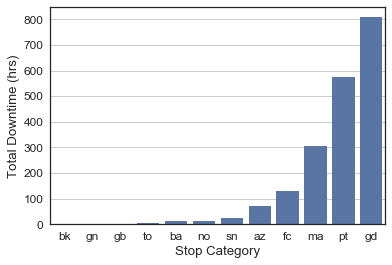

In [42]:
durations = batches[(batches.start_time >= 'nov 2015') &
                    (batches.batch_cat != 'msf') &
                    (batches.start_time <= 'apr 20 2016')].groupby(
    'batch_cat').down_dur.sum().reset_index().sort_values(by='down_dur')
durations.down_dur = durations.down_dur.apply(
    lambda x: x / np.timedelta64(1, 'h'))

durations.loc[durations.batch_cat == 'test', 'batch_cat'] = 'no'
durations.loc[durations.batch_cat == 'azimuth', 'batch_cat'] = 'az'
durations.loc[durations.batch_cat == 'brake', 'batch_cat'] = 'bk'
durations.loc[durations.batch_cat == 'gearbox', 'batch_cat'] = 'gb'
durations.loc[durations.batch_cat == 'grid', 'batch_cat'] = 'gd'
durations.loc[durations.batch_cat == 'generator', 'batch_cat'] = 'gn'
durations.loc[durations.batch_cat == 'maintenance', 'batch_cat'] = 'ma'
durations.loc[durations.batch_cat == 'pitch', 'batch_cat'] = 'pt'
durations.loc[durations.batch_cat == 'sensor', 'batch_cat'] = 'sn'
durations.loc[durations.batch_cat == 'tower', 'batch_cat'] = 'to'
durations.loc[durations.batch_cat == 'battery', 'batch_cat'] = 'ba'

sns.set(font_scale=1.2)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=durations, x='batch_cat', y='down_dur', ax=ax,
            color=sns.color_palette()[0])
ax.set(xlabel='Stop Category', ylabel='Total Downtime (hrs)')
ax.yaxis.grid()

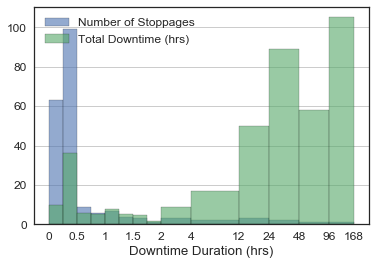

In [43]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

# get durations of pitch batches
pitch_durations = batches.loc[
    (batches.start_time >= 'nov 2015') & (batches.batch_cat == 'pitch') &
    (batches.start_time <= 'apr 20 2016'), ['turbine_num', 'down_dur']
].sort_values(by='down_dur')

# convert to hours
pitch_durations.down_dur = pitch_durations.down_dur.apply(
    lambda x: x / np.timedelta64(1, 'h'))

# set the styles
sns.set(font_scale=1.2)
sns.set_style('white')

# initialise axes
fig, ax = plt.subplots(figsize=(6,4))

# create histogram bins
bins = np.append(np.arange(0, 2.25, .25), np.array([4, 12, 24, 48, 96, 168]))

# create the first histogram
hist_kws = {'ec':'black','alpha':0.6, 'label': 'Number of Stoppages'}
sns.distplot(
    pitch_durations.down_dur, ax=ax, kde=False, norm_hist=False, bins=bins,
    hist_kws=hist_kws, color=sns.color_palette()[0])

# create the second histogram, with added weights
hist_kws2 = {'ec': 'black','alpha': 1, 'weights': pitch_durations.down_dur,
             'alpha': 0.6, 'label': 'Total Downtime (hrs)'}
sns.distplot(pitch_durations.down_dur, ax=ax, kde=False, norm_hist=False,
             bins=bins, hist_kws=hist_kws2, color=sns.color_palette()[1])

# histogram x scale
xticks = [0, .5, 1, 1.5, 2, 4, 12, 24, 48, 96, 168]
ax.set_xscale('symlog', linthreshx=2)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))

ax.set(xlabel='Downtime Duration (hrs)', xticks=xticks);
ax.yaxis.grid()
ax.legend()

## Plots for thesis

In [13]:
mpl.rcdefaults()

mpl.rcParams.update(
    {'font.size':12, 'text.usetex':True, 'font.family':'serif',
     'font.serif':'Charter', 'axes.spines.top': False,
     'axes.spines.right': False})

In [11]:
%matplotlib inline

C:\Users\leahy\Miniconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


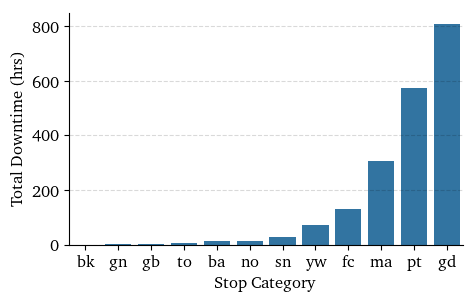

In [15]:
durations = batches[(batches.start_time >= 'nov 2015') &
                    (batches.batch_cat != 'msf') &
                    (batches.start_time <= 'apr 20 2016')].groupby(
    'batch_cat').down_dur.sum().reset_index().sort_values(by='down_dur')
durations.down_dur = durations.down_dur.apply(
    lambda x: x / np.timedelta64(1, 'h'))

durations.loc[durations.batch_cat == 'test', 'batch_cat'] = 'no'
durations.loc[durations.batch_cat == 'azimuth', 'batch_cat'] = 'yw'
durations.loc[durations.batch_cat == 'brake', 'batch_cat'] = 'bk'
durations.loc[durations.batch_cat == 'gearbox', 'batch_cat'] = 'gb'
durations.loc[durations.batch_cat == 'grid', 'batch_cat'] = 'gd'
durations.loc[durations.batch_cat == 'generator', 'batch_cat'] = 'gn'
durations.loc[durations.batch_cat == 'maintenance', 'batch_cat'] = 'ma'
durations.loc[durations.batch_cat == 'pitch', 'batch_cat'] = 'pt'
durations.loc[durations.batch_cat == 'sensor', 'batch_cat'] = 'sn'
durations.loc[durations.batch_cat == 'tower', 'batch_cat'] = 'to'
durations.loc[durations.batch_cat == 'battery', 'batch_cat'] = 'ba'

# sns.set(font_scale=1.2)
# sns.set_style('white')

fig, ax = plt.subplots()

sns.barplot(data=durations, x='batch_cat', y='down_dur', ax=ax,
            color=sns.color_palette()[0])
ax.set(xlabel='Stop Category', ylabel='Total Downtime (hrs)')

# reformat yticks
ax.set_yticklabels(ax.get_yticks())
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

width = (14.5/2.54) * .8
height = width/1.618

ax.grid(linestyle='--', color='black', alpha=0.15, axis='y')

fig.set_size_inches(width, height)
# fig.subplots_adjust(left=.11,bottom=.13,top=.98, right=.99)
fig.tight_layout(pad=0)

fig.savefig('C:/Users/leahy/Google Drive/UCC/PhD/Thesis/latex files/figs/'\
            'batch_cat_durations.pdf')

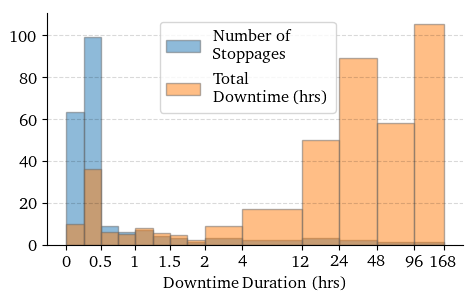

In [127]:
# get durations of pitch batches
pitch_durations = batches.loc[
    (batches.start_time >= 'nov 2015') & (batches.batch_cat == 'pitch') &
    (batches.start_time <= 'apr 20 2016'), ['turbine_num', 'down_dur']
].sort_values(by='down_dur')

# convert to hours
pitch_durations.down_dur = pitch_durations.down_dur.apply(
    lambda x: x / np.timedelta64(1, 'h'))

# initialise axes
fig, ax = plt.subplots(figsize=(6,4))

# create histogram bins
bins = np.append(np.arange(0, 2.25, .25), np.array([4, 12, 24, 48, 96, 168]))

# create the first histogram
hist_kws = {'ec':'#666666','alpha':.5, 'label': 'Number of\nStoppages'}
sns.distplot(
    pitch_durations.down_dur, ax=ax, kde=False, norm_hist=False, bins=bins,
    hist_kws=hist_kws)

# create the second histogram, with added weights
hist_kws2 = {'ec': '#666666','alpha': .5, 'weights': pitch_durations.down_dur,
             'label': 'Total\nDowntime (hrs)'}
sns.distplot(pitch_durations.down_dur, ax=ax, kde=False, norm_hist=False,
             bins=bins, hist_kws=hist_kws2)

# histogram x scale
xticks = [0, .5, 1, 1.5, 2, 4, 12, 24, 48, 96, 168]
ax.set_xscale('symlog', linthreshx=2)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))

# for some reason, minor ticks are appearing
ax.tick_params(axis='x',which='minor',bottom='off')

# reformat yticks
ax.set_yticklabels(ax.get_yticks())
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

ax.legend(bbox_to_anchor=(.25, 1))

ax.set(xlabel='Downtime Duration (hrs)', xticks=xticks)
width = (14.5/2.54) * .8
height = width/1.618

ax.grid(linestyle='--', color='black', alpha=0.15, axis='y')

fig.set_size_inches(width, height)
# fig.subplots_adjust(left=.11,bottom=.13,top=.98, right=.99)
fig.tight_layout(pad=0)
fig.savefig('C:/Users/leahy/Google Drive/UCC/PhD/Thesis/latex files/figs/'\
            'pitch_durations.pdf')

# Deprecated

#### Deprecated

The following are efforts to make the feature selection transformer work

---
The below is a simple transformer for selecting the features to be used in the pipeline

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    """Simple transfomer to select features in X corresponding to the column
    names of features in the dataframe from which X is derived.
    
    """
    def __init__(self, all_features, included_features):
        self.all_features = all_features
        self.included_features = included_features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        ids = np.in1d(self.all_features, self.included_features)
        return X[:, ids]

# all_features = tuple(scada_l.columns.values)
# included_features = ('time', 'turbine_num')
# x = scada_l.head().values

# fs = FeatureSelector(all_features, included_features)
# fs.transform(x)

In [ ]:
# Classification variables
X_train = scada_l.loc[scada_l.turbine_num != 2].values
X_test = scada_l.loc[scada_l.turbine_num == 2].values

y_train = scada_l.loc[scada_l.turbine_num != 2, 'pre_stop'].values
y_test = scada_l.loc[scada_l.turbine_num == 2, 'pre_stop'].values

groups = scada_l[scada_l.turbine_num != 2].turbine_num.values

# cv scheme
lpgo = LeavePGroupsOut(n_groups=1)

# setting up the pipeline
pipe = ImbPipeline([
    ('fs', FeatureSelector(all_features, selected_features)),
    ('rus', RandomUnderSampler(ratio='majority', random_state=42)),
    ('rfc', RandomForestClassifier(n_jobs = -1, random_state=42))
])

# param_grid = {
#     'fs__all_features': tuple(scada_l.columns.values),
#     'fs__included_features': (features, features_with_alarms)}

param_grid = {'rfc__max_features': (3, 4)}

# setting up the gridsearch
gs = GridSearchCV(pipe, param_grid=param_grid, scoring=['precision', 'recall'],
                  n_jobs=-1, cv=lpgo, refit='precision')

gs.fit(X_train, y_train, groups)

In [ ]:
# Classification variables
X_train = scada_l.loc[scada_l.turbine_num != 2, features].values
X_test = scada_l.loc[scada_l.turbine_num == 2, features].values

y_train = scada_l.loc[scada_l.turbine_num != 2, 'pre_stop'].values
y_test = scada_l.loc[scada_l.turbine_num == 2, 'pre_stop'].values

groups = scada_l[scada_l.turbine_num != 2].turbine_num.values

# cv scheme
lpgo = LeavePGroupsOut(n_groups=1)

# setting up the pipeline
pipe = ImbPipeline([('rus', RandomUnderSampler(ratio='majority', random_state=42)),
    ('rfc', RandomForestClassifier(n_jobs = -1, random_state=65))
])

# param_grid = {
#     'fs__all_features': tuple(scada_l.columns.values),
#     'fs__included_features': (features, features_with_alarms)}

param_grid = {'rfc__max_features': (3, 4)}

# setting up the gridsearch
gs = GridSearchCV(pipe, param_grid=param_grid, scoring=['precision', 'recall'],
                  n_jobs=-1, cv=lpgo, refit='precision')

gs.fit(X_train, y_train, groups)

In [ ]:
from sklearn.pipeline import Pipeline

# ClassiPipelinecation variables
X_train = scada_l.loc[scada_l.turbine_num != 2, features].values
X_test = scada_l.loc[scada_l.turbine_num == 2, features].values

y_train = scada_l.loc[scada_l.turbine_num != 2, 'pre_stop'].values
y_test = scada_l.loc[scada_l.turbine_num == 2, 'pre_stop'].values

groups = scada_l[scada_l.turbine_num != 2].turbine_num.values

# cv scheme
lpgo = LeavePGroupsOut(n_groups=1)

rus = RandomUnderSampler(ratio='majority', random_state=42, return_indices=True)

X_rus, y_rus, ind = rus.fit_sample(X_train, y_train)

groups_rus = groups[ind]

# setting up the pipeline
pipe = Pipeline([
    ('fs', FeatureSelector(tuple(features), ('wind_speed', 'kw'))),
    ('rfc', RandomForestClassifier(n_jobs = -1, random_state=42))
])

# param_grid = {
#     'fs__all_features': tuple(scada_l.columns.values),
#     'fs__included_features': (features, features_with_alarms)}

param_grid = {'rfc__max_features': (3, 4)}

# setting up the gridsearch
gs = GridSearchCV(pipe, param_grid=param_grid, scoring='precision',
                  n_jobs=-1)

gs.fit(X_rus, y_rus)

---
The following are comparisons that have been rolled into the grid selection pipeline in section 3.4

Without the num_48h and dur_48h features, this is the result:

In [22]:


pipe = ImbPipeline([
    ('rus', RandomUnderSampler(ratio='majority', random_state=43)),
    ('rfc', RandomForestClassifier(n_jobs=-1, random_state=43))])

lpgo = LeavePGroupsOut(n_groups=1)

with warnings.catch_warnings():
    scores = pd.DataFrame(cross_validate(
        pipe, X, y, groups, ['precision', 'recall'], lpgo))

print(scores[['test_precision', 'test_recall']].mean())

test_precision    0.174883
test_recall       0.272322
dtype: float64


The results using `random_state=42`:

    test_precision    0.171144
    test_recall       0.252734

and with those features:

In [23]:
X = scada_l[[
'wind_speed', 'kw', 'wind_speed_sd', 'wind_speed_max', 'torque_actual_value',
'blade_1_actual_angle', 'blade_2_actual_angle', 'blade_3_actual_angle',
'blade_1_2_act_angle_diff', 'blade_2_3_act_angle_diff',
'blade_3_1_act_angle_diff', 'num_48h', 'dur_48h']].values
# X = scada_l[all_pitch_features].values

y = scada_l['pre_stop'].values

groups = scada_l.turbine_num.values

pipe = ImbPipeline([
    ('rus', RandomUnderSampler(ratio='majority', random_state=43)),
    ('rfc', RandomForestClassifier(n_jobs=-1, random_state=43))])

lpgo = LeavePGroupsOut(n_groups=1)

with warnings.catch_warnings():
    scores = pd.DataFrame(cross_validate(
        pipe, X, y, groups, ['precision', 'recall'], lpgo))

print(scores[['test_precision', 'test_recall']].mean())

test_precision    0.166598
test_recall       0.245520
dtype: float64


The results using `random_state=42`:

    test_precision    0.168486
    test_recall       0.257430

Hence, performance is marginally better without the use of the number/duration of alarms.

---
Using standard scaler, polynomial features & PCA:

In [24]:
X = scada_l[[
'wind_speed', 'kw', 'wind_speed_sd', 'wind_speed_max', 'torque_actual_value',
'blade_1_actual_angle', 'blade_2_actual_angle', 'blade_3_actual_angle',
'blade_1_2_act_angle_diff', 'blade_2_3_act_angle_diff',
'blade_3_1_act_angle_diff']].values
# X = scada_l[all_pitch_features].values

y = scada_l['pre_stop'].values

groups = scada_l.turbine_num.values

lpgo = LeavePGroupsOut(n_groups=1)

pipe = make_imbpipeline(
    StandardScaler(),
    RandomUnderSampler(random_state=42),
    PolynomialFeatures(degree=2),
    PCA(n_components=3, random_state=42),
    RandomForestClassifier(n_jobs=-1, random_state=42))

with warnings.catch_warnings():
    scores = pd.DataFrame(cross_validate(
        pipe, X, y, groups, ['precision', 'recall'], lpgo))

print(scores[['test_precision', 'test_recall']].mean())

test_precision    0.158841
test_recall       0.402243
dtype: float64


---
Without scaler:

In [25]:
pipe = make_imbpipeline(
    #StandardScaler(),
    RandomUnderSampler(random_state=42),
    PolynomialFeatures(degree=2),
    PCA(n_components=3, random_state=42),
    RandomForestClassifier(n_jobs=-1, random_state=42))

with warnings.catch_warnings():
    scores = pd.DataFrame(cross_validate(
        pipe, X, y, groups, ['precision', 'recall'], lpgo))

print(scores[['test_precision', 'test_recall']].mean())

test_precision    0.156803
test_recall       0.407814
dtype: float64


Slightly better with scaler

---
No polynomials:

In [26]:
pipe = make_imbpipeline(
    StandardScaler(),
    RandomUnderSampler(random_state=42),
    #PolynomialFeatures(degree=2),
    PCA(n_components=3, random_state=42),
    RandomForestClassifier(n_jobs=-1, random_state=42))

with warnings.catch_warnings():
    scores = pd.DataFrame(cross_validate(
        pipe, X, y, groups, ['precision', 'recall'], lpgo))

print(scores[['test_precision', 'test_recall']].mean())

test_precision    0.161035
test_recall       0.390405
dtype: float64


More polynomials:

In [27]:
pipe = make_imbpipeline(
    StandardScaler(),
    RandomUnderSampler(random_state=42),
    PolynomialFeatures(degree=3),
    PCA(n_components=3, random_state=42),
    RandomForestClassifier(n_jobs=-1, random_state=42))

with warnings.catch_warnings():
    scores = pd.DataFrame(cross_validate(
        pipe, X, y, groups, ['precision', 'recall'], lpgo))

print(scores[['test_precision', 'test_recall']].mean())

test_precision    0.156838
test_recall       0.463917
dtype: float64


So, more polynomials give better results!

---
No polynomials:

In [28]:
pipe = make_imbpipeline(
    StandardScaler(),
    RandomUnderSampler(random_state=42),
    PolynomialFeatures(degree=1),
    PCA(n_components=3, random_state=42),
    RandomForestClassifier(n_jobs=-1, random_state=42))

with warnings.catch_warnings():
    scores = pd.DataFrame(cross_validate(
        pipe, X, y, groups, ['precision', 'recall'], lpgo))

print(scores[['test_precision', 'test_recall']].mean())

test_precision    0.161035
test_recall       0.390405
dtype: float64


---
Less PCA:

In [29]:
pipe = make_imbpipeline(
    StandardScaler(),
    RandomUnderSampler(random_state=42),
    PolynomialFeatures(degree=1),
    PCA(n_components=2, random_state=42),
    RandomForestClassifier(n_jobs=-1, random_state=42))

with warnings.catch_warnings():
    scores = pd.DataFrame(cross_validate(
        pipe, X, y, groups, ['precision', 'recall'], lpgo))

print(scores[['test_precision', 'test_recall']].mean())

test_precision    0.159633
test_recall       0.434442
dtype: float64


---
More PCA:

In [30]:
pipe = make_imbpipeline(
    StandardScaler(),
    RandomUnderSampler(random_state=42),
    PolynomialFeatures(degree=2),
    PCA(n_components=3, random_state=42),
    RandomForestClassifier(n_jobs=-1, random_state=42))

with warnings.catch_warnings():
    scores = pd.DataFrame(cross_validate(
        pipe, X, y, groups, ['precision', 'recall'], lpgo))

print(scores[['test_precision', 'test_recall']].mean())

test_precision    0.158834
test_recall       0.402243
dtype: float64


---
No PCA:

In [31]:
pipe = make_imbpipeline(
    StandardScaler(),
    RandomUnderSampler(random_state=42),
    PolynomialFeatures(degree=2),
    #PCA(n_components=3, random_state=42),
    RandomForestClassifier(n_jobs=-1, random_state=42))

with warnings.catch_warnings():
    scores = pd.DataFrame(cross_validate(
        pipe, X, y, groups, ['precision', 'recall'], lpgo))

print(scores[['test_precision', 'test_recall']].mean())

test_precision    0.173498
test_recall       0.266037
dtype: float64


---

---

The best results then, were on 1st deg polynomial (i.e. no polynomial) with 2 PCA features.


In [32]:
pipe = make_imbpipeline(
    StandardScaler(),
    RandomUnderSampler(random_state=42),
    PolynomialFeatures(degree=1),
    PCA(n_components=2, random_state=42),
    RandomForestClassifier(n_jobs=-1, random_state=42))

with warnings.catch_warnings():
    scores = pd.DataFrame(cross_validate(
        pipe, X, y, groups, ['precision', 'recall'], lpgo))

print(scores[['test_precision', 'test_recall']].mean())

test_precision    0.159622
test_recall       0.434442
dtype: float64


This is the best scores:

In [33]:
scores

,fit_time,score_time,test_precision,test_recall,train_precision,train_recall
0,0.979366,0.253675,0.463676,0.545023,0.288362,0.961041
1,1.091776,0.249693,0.198198,0.357966,0.359383,0.957809
2,1.038634,0.253634,0.348240,0.551298,0.318687,0.957385
3,1.057660,0.232620,0.124856,0.270354,0.370230,0.961524
4,1.282435,0.252666,0.019841,0.262425,0.384529,0.958432
5,1.070553,0.251694,0.238630,0.177364,0.357693,0.962718
6,1.049596,0.243643,0.148617,0.412965,0.360879,0.959070
7,1.231987,0.249657,0.008976,0.265873,0.384409,0.959606
8,1.143920,0.251664,0.163957,0.488622,0.363123,0.960140
9,1.177952,0.246655,0.012353,0.824701,0.410771,0.958444


From above, we see that the first validation fold had the best scores, so we use this to implement our evaluation system.

First, we must check which actual turbine was used as the test set here, to replicate that for our fully trained model:

In [34]:
for train, test in lpgo.split(scada_l, groups=groups):
    print(scada_l.iloc[train].turbine_num.unique(),
          scada_l.iloc[test].turbine_num.unique())

[ 3  8  9 10 11 15 18 20 21 32] [2]
[ 2  8  9 10 11 15 18 20 21 32] [3]
[ 2  3  9 10 11 15 18 20 21 32] [8]
[ 2  3  8 10 11 15 18 20 21 32] [9]
[ 2  3  8  9 11 15 18 20 21 32] [10]
[ 2  3  8  9 10 15 18 20 21 32] [11]
[ 2  3  8  9 10 11 18 20 21 32] [15]
[ 2  3  8  9 10 11 15 20 21 32] [18]
[ 2  3  8  9 10 11 15 18 21 32] [20]
[ 2  3  8  9 10 11 15 18 20 32] [21]
[ 2  3  8  9 10 11 15 18 20 21] [32]


So, turbine 2 will be our test set, and every other turbine our training set.